In [1]:
!pip install scikit-learn glob2 tqdm pesq pystoi


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
import os

import numpy as np

# Definir o nível de log do TensorFlow para ERROR
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, Activation, Dropout, Conv1D, Conv1DTranspose, MaxPooling1D, concatenate, Concatenate, LSTM, Dense, SimpleRNN, BatchNormalization, Dropout, BatchNormalization, Add, Flatten, UpSampling1D, UpSampling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import LayerNormalization, Dropout, MultiHeadAttention, Conv2D, Conv2DTranspose, MaxPooling2D, Permute, Reshape, AveragePooling2D, GlobalAveragePooling2D, multiply, GlobalAveragePooling1D, Multiply
from tensorflow.keras import backend as K

# import sounddevice as sd
from scipy.signal import butter, filtfilt, stft, istft
from scipy.signal import resample
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy.io import wavfile
from glob2 import glob
from tqdm import tqdm
from pesq import pesq
from pystoi import stoi
import matplotlib.pyplot as plt


from utils import load_wav, generate_white_gaussian_noise, add_white_gaussian_noise, undersample_signal_with_antialiasing, somar_sinais, calculate_snr, save_sound_to_wav
import matplotlib.pyplot as plt
from sound import Sound

In [3]:
try:
 device_name = os.environ['COLAB_TPU_ADDR']
 TPU_ADDRESS = 'grpc://' + device_name
 print('Found TPU at: {}'.format(TPU_ADDRESS))
except KeyError:
 print('TPU not found')

gpu=tf.test.gpu_device_name()
if gpu=="":
  print("Computador sem GPU.")
else:
  print("Computador com GPU:",tf.test.gpu_device_name())
  from tensorflow.python.client import device_lib
  devices=device_lib.list_local_devices()
  print("Dispositivos:",[x.physical_device_desc for x in devices if x.physical_device_desc!=""])
print()

!lsb_release -a | grep "Description" #imprime qual é o sistema operacional
!echo

!cat /proc/cpuinfo | grep -E "model name|core" #especificações de CPU
!echo 

!cat /proc/meminfo  | grep "Mem" #especificações de RAM

TPU not found
Computador com GPU: /device:GPU:0
Dispositivos: ['device: 0, name: NVIDIA GeForce GTX 1070 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1']

No LSB modules are available.
Description:	Ubuntu 20.04.5 LTS

model name	: Intel(R) Core(TM) i5-8600K CPU @ 3.60GHz
core id		: 0
cpu cores	: 6
model name	: Intel(R) Core(TM) i5-8600K CPU @ 3.60GHz
core id		: 1
cpu cores	: 6
model name	: Intel(R) Core(TM) i5-8600K CPU @ 3.60GHz
core id		: 2
cpu cores	: 6
model name	: Intel(R) Core(TM) i5-8600K CPU @ 3.60GHz
core id		: 3
cpu cores	: 6
model name	: Intel(R) Core(TM) i5-8600K CPU @ 3.60GHz
core id		: 4
cpu cores	: 6
model name	: Intel(R) Core(TM) i5-8600K CPU @ 3.60GHz
core id		: 5
cpu cores	: 6

MemTotal:       16312084 kB
MemFree:          174628 kB
MemAvailable:   12359908 kB


# Descrição do Código

O código apresenta uma função chamada `get_sounds_from_folder` que recebe um caminho de diretório e um padrão como entrada e retorna uma lista de arquivos de som que correspondem ao padrão dentro do diretório e de seus subdiretórios até uma profundidade máxima especificada.

Em seguida, o código define uma série de operações para carregar arquivos de som, processá-los e prepará-los para treinamento. Ele carrega arquivos de ruído e sons limpos, realiza uma série de transformações nesses sons (como subamostragem e remodelagem), e os armazena em listas.

Após isso, o código realiza algumas operações de pré-processamento nos dados, como normalização e ajuste de limites, e exibe informações sobre a forma (shape) e os valores máximo e mínimo dos sons limpos e dos ruídos.

Em seguida, é definida uma classe chamada `DataGenerator`, que contém três métodos: `generate_sample_pesq`, `generate_sample_completo` e `generate_sample_pre`. Esses métodos geram lotes de exemplos de treinamento a partir dos arquivos de som e ruído carregados anteriormente. Cada lote contém um conjunto de sons e ruídos, aos quais são aplicadas diversas transformações e cálculos, como adição de ruído, cálculo da nota PESQ e formatação dos dados para treinamento. Os lotes são retornados em forma de geradores para serem utilizados no treinamento de um modelo.

No geral, o código carrega sons e ruídos, realiza transformações nos dados e os prepara para treinamento, além de fornecer métodos para gerar lotes de exemplos de treinamento com diferentes configurações.

In [4]:
base_shape_size = 2000

In [6]:
sound_base = Sound('./Base/', './ESC-50-master/audio/', base_shape_size)

Loading noise files: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 246.95it/s]


In [7]:
def calcular_componentes_fourier(sinal):
    if len(sinal.shape) == 3 and sinal.shape[2] == 1:
        sinal = sinal.reshape(sinal.shape[0], sinal.shape[1])

    componentes = np.fft.fft(sinal)
    # Obter a magnitude máxima dos componentes
    # max_magnitude = np.max(np.abs(componentes), axis=1).reshape(-1, 1)
    # Normalizar os componentes para o intervalo [-1, 1]
    max_magnitude = 1
    # componentes_normalizados = componentes / max_magnitude
    res = np.stack((np.real(componentes), np.imag(componentes)), axis=-1)

    return np.array(res), max_magnitude

def reconstruir_sinal(componentes, max_magnitude):
    comp = componentes[:, :, 0] + 1j * componentes[:, :, 1]
    print(comp.shape)
    sinal_reconstruido = np.fft.ifft(comp) * max_magnitude
    return np.real(sinal_reconstruido)

In [8]:
class DataGenerator:
    def __init__(self, sound_files, noise_files):
        self.sound_files = sound_files
        self.noise_files = noise_files
        self.MIN_NOISE_LEVEL = 5
        self.MAX_NOISE_LEVEL = 30
        
    def normalize_array(self, array):
        min_val = np.min(array)
        max_val = np.max(array)
        normalized_array = (array - min_val) / (max_val - min_val)
        normalized_array = normalized_array * 2 - 1
        return normalized_array

    def calculate_stft(self, signal):
        desired_size = signal.shape[0]
        window_size = 2 * (desired_size - 1)

        _, _, stft_data = stft(signal.flatten(), nperseg=window_size, noverlap=window_size - desired_size)
        stft_real = np.real(stft_data)
        stft_imag = np.imag(stft_data)

        # Normalização das componentes da STFT
        norm_factor = np.max(np.abs(stft_data))
        stft_real /= norm_factor
        stft_imag /= norm_factor

        stft_components = np.concatenate((stft_real, stft_imag), axis=1)
        return stft_components, norm_factor

    def reconstruct_signal(self, stft_components, norm_factor):
        # Desfaz a normalização das componentes da STFT
        stft_components *= norm_factor

        stft_data = stft_components[:, :stft_components.shape[1]//2] + 1j * stft_components[:, stft_components.shape[1]//2:]
        _, signal = istft(stft_data)
        return signal.reshape(-1, 1)

    def generate_sample_pesq(self, batch_size=32):
        while True:
            # Carrega um lote de sons
            sound_batch_choices = np.random.choice(self.sound_files.shape[0], size=batch_size, replace=False)
            sound_batch = self.sound_files[sound_batch_choices]
            
            # Carrega um lote de ruídos
            noise_batch_choices = np.random.choice(self.noise_files.shape[0], size=batch_size, replace=False)
            noise_batch = self.noise_files[noise_batch_choices]
            
            x_train = []
            y_train = []
            
            # Adiciona ruído a cada som e calcula a nota PESQ
            for sound, noise in zip(sound_batch, noise_batch):
#                 sound = self.normalize_array(sound)
#                 noise = self.normalize_array(noise)
                
                sr = np.random.randint(-5, 90, size=(1,)[0])
                noisy_sound = somar_sinais(sound, noise, sr)
#                 noisy_sound = self.normalize_array(noisy_sound)
                
                noisy_sound = add_white_gaussian_noise(noisy_sound, np.random.randint(7, 90, size=(1,)[0]))
                noisy_sound = np.clip(noisy_sound, -1, 1)
#                 noisy_sound = self.normalize_array(noisy_sound)
    
                # Calcula a nota PESQ
                try:
                    pesq_score = pesq(8000, sound, noisy_sound, 'nb')
                except:
                    continue

                valor_min = -0.6
                valor_max = 4.6
                pesq_score = (pesq_score - valor_min) / (valor_max - valor_min)
                
                # Formata dados para treinamento
                original_sound = sound #.reshape((base_shape_size, 1))
                d_sound = noisy_sound #.reshape((base_shape_size, 1))
                
                original_sound, ms = calcular_componentes_fourier(original_sound)
                d_sound, md = calcular_componentes_fourier(d_sound)
                
#                 # Formata dados para treinamento
#                 original_sound = sound.reshape((base_shape_size, 1))
#                 d_sound = noisy_sound.reshape((base_shape_size, 1))
                
                merged_array = np.concatenate((original_sound, d_sound), axis=-1)
                
                # Adiciona o exemplo ao lote de treinamento
                x_train.append(merged_array)
                y_train.append(pesq_score)
            
            yield np.array(x_train), np.array(y_train)
            
    def generate_sample_completo(self, batch_size=32):
        while True:
            # Carrega um lote de sons
            sound_batch_choices = np.random.choice(self.sound_files.shape[0], size=batch_size, replace=False)
            sound_batch = self.sound_files[sound_batch_choices]
            
            # Carrega um lote de ruídos
            noise_batch_choices = np.random.choice(self.noise_files.shape[0], size=batch_size, replace=False)
            noise_batch = self.noise_files[noise_batch_choices]
            
            x1_train = []
            x2_train = []
            y_train = []
            
            # Adiciona ruído a cada som e calcula a nota PESQ
            for sound, noise in zip(sound_batch, noise_batch):
#                 sound = self.normalize_array(sound)
#                 noise = self.normalize_array(noise)

                sr = np.random.randint(self.MIN_NOISE_LEVEL, self.MAX_NOISE_LEVEL, size=(1,)[0])
                noisy_sound = somar_sinais(sound, noise, sr)
#                 noisy_sound = self.normalize_array(noisy_sound)
                
                noisy_sound = add_white_gaussian_noise(noisy_sound, np.random.randint(5, 50, size=(1,)[0]))
                noisy_sound = np.clip(noisy_sound, -1, 1)
#                 noisy_sound = self.normalize_array(noisy_sound)

                # Calcula a nota PESQ
#                 try:
#                     pesq_score = pesq(8000, sound, noisy_sound, 'nb')
#                 except:
#                     continue
#                 # Calcula a nota PESQ
#                 valor_min = -0.6
#                 valor_max = 4.6
#                 pesq_score = (pesq_score - valor_min) / (valor_max - valor_min)
#                 pesq_score = min(1., pesq_score + 0.13)
                pesq_score = 1.
                # Formata dados para treinamento
                original_sound = sound #.reshape((base_shape_size, 1))
                d_sound = noisy_sound #.reshape((base_shape_size, 1))
                
                original_sound, ms = calcular_componentes_fourier(original_sound)
                d_sound, md = calcular_componentes_fourier(d_sound)
                
                # Adiciona o exemplo ao lote de treinamento
                x1_train.append(d_sound)
                x2_train.append(original_sound)
                y_train.append(pesq_score)
            
            yield [np.array(x1_train), np.array(x2_train)], np.array(y_train)

    def generate_sample_pre(self, batch_size=32):
        while True:
            # Carrega um lote de sons
            sound_batch_choices = np.random.choice(self.sound_files.shape[0], size=batch_size, replace=False)
            sound_batch = self.sound_files[sound_batch_choices]
            
            # Carrega um lote de ruídos
            noise_batch_choices = np.random.choice(self.noise_files.shape[0], size=batch_size, replace=False)
            noise_batch = self.noise_files[noise_batch_choices]
            
            x1_train = []
            y_train = []
            
            # Adiciona ruído a cada som e calcula a nota PESQ
            for sound, noise in zip(sound_batch, noise_batch):
#                 sound = self.normalize_array(sound)
#                 noise = self.normalize_array(noise)

                sr = np.random.randint(self.MIN_NOISE_LEVEL, self.MAX_NOISE_LEVEL, size=(1,)[0])
                noisy_sound = somar_sinais(sound, noise, sr)
#                 noisy_sound = self.normalize_array(noisy_sound)
                
                noisy_sound = add_white_gaussian_noise(noisy_sound, np.random.randint(7, 50, size=(1,)[0]))
#                 # noisy_sound = add_white_gaussian_noise(sound, np.random.randint(5, 50, size=(1,)[0]))
#                 noisy_sound = self.normalize_array(noisy_sound)
                noisy_sound = np.clip(noisy_sound, -1, 1)
                
                # Formata dados para treinamento
                original_sound = sound #.reshape((base_shape_size, 1))
                d_sound = noisy_sound #.reshape((base_shape_size, 1))
                
                original_sound, ms = calcular_componentes_fourier(original_sound)
                d_sound, md = calcular_componentes_fourier(d_sound)
                
                # Adiciona o exemplo ao lote de treinamento
                x1_train.append(d_sound)
                y_train.append(original_sound)
            
            yield np.array(x1_train), np.array(y_train)

In [9]:
class PlotLossesCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        self.epochs = 0
        self.fig, self.ax = plt.subplots()

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.epochs += 1

        self.ax.clear()
        self.ax.plot(range(1, self.epochs+1), self.losses, label='training')
        self.ax.plot(range(1, self.epochs+1), self.val_losses, label='validation')
        self.ax.legend()
        self.ax.set_xlabel('Epoch')
        self.ax.set_ylabel('Loss')
        self.ax.set_title('Training and Validation Loss')

## Modelo para a PESQ

1. Uma função `cnn()` é definida para construir a arquitetura do modelo CNN.
2. O modelo é criado chamando `cnn()`, e um resumo do modelo é impresso.
3. Instâncias de `DataGenerator` são criadas para os dados de treinamento e validação.
4. O modelo é compilado com o otimizador 'adam' e a função de perda 'mse' (erro quadrático médio).
5. Parâmetros de treinamento são definidos, como tamanho do lote e etapas por época.
6. O treinamento começa com um loop que itera três vezes para três épocas.
7. Para cada época, um novo lote de validação é gerado usando o gerador de dados de validação.
8. O modelo é treinado usando o gerador de dados de treinamento, com as etapas por época, épocas, dados de validação e um callback para visualização de perda.
9. Após o treinamento, o modelo é salvo em um arquivo chamado 'pesq-generator-16.h5'.

In [10]:
def cnn(input_layer, kernel_size=3):
    # Define the input shape
#     input_shape = (base_shape_size, 2)

    # Define the model architecture
#     input_layer = Input(shape=input_shape)

    conv1 = Conv1D(16, kernel_size, activation='relu')(input_layer)
    conv1 = Conv1D(16, kernel_size, activation='relu')(conv1)
    pool1 = MaxPooling1D(pool_size=2)(conv1)

    conv2 = Conv1D(32, kernel_size, activation='relu')(pool1)
    conv2 = Conv1D(32, kernel_size, activation='relu')(conv2)
    pool2 = MaxPooling1D(pool_size=2)(conv2)
    
    conv3 = Conv1D(64, kernel_size, activation='relu')(pool2)
    conv3 = Conv1D(64, kernel_size, activation='relu')(conv3)
    pool3 = MaxPooling1D(pool_size=2)(conv3)

    conv4 = Conv1D(128, kernel_size, activation='relu')(pool3)
    conv4 = Conv1D(128, kernel_size, activation='relu')(conv4)
    pool4 = MaxPooling1D(pool_size=2)(conv4)
    
    conv5 = Conv1D(256, kernel_size, activation='relu')(pool4)
    conv5 = Conv1D(256, kernel_size, activation='relu')(conv5)
    pool5 = MaxPooling1D(pool_size=2)(conv4)
    
    conv6 = Conv1D(512, kernel_size, activation='relu')(pool5)
    conv6 = Conv1D(512, kernel_size, activation='relu')(conv6)
    pool6 = MaxPooling1D(pool_size=2)(conv6)

    flatten = Flatten()(pool6)
    dense1 = Dense(256, activation='relu')(flatten)
    dense1 = Dense(256, activation='relu')(dense1)
#     output_layer = Dense(1, activation='sigmoid')(dense1)

#     model = Model(inputs=input_layer, outputs=output_layer)
    return dense1

In [11]:
# Crie uma instância do DataGenerator
data_generator_train = DataGenerator(sound_base.train_X, sound_base.noise_sounds)
data_generator_val = DataGenerator(sound_base.val_X, sound_base.noise_sounds)

In [12]:
input_shape = (base_shape_size, 4)

input_layer = Input(shape=input_shape)

in1 = cnn(input_layer, kernel_size=3)
# in2 = cnn(input_layer, kernel_size=9)
# in3 = cnn(input_layer, kernel_size=17)
# in4 = cnn(input_layer, kernel_size=35)
# in5 = cnn(input_layer, kernel_size=71)
# in6 = cnn(input_layer, kernel_size=143)

# den = concatenate([in1, in2, in3, in4])
# den = concatenate([in1, in6])

# output = Dense(128, activation='relu')(in1)
# output = Dense(64, activation='relu')(output)

output_layer = Dense(1, activation='sigmoid')(in1)

model = Model(inputs=input_layer, outputs=output_layer)

In [13]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2000, 4)]         0         
                                                                 
 conv1d (Conv1D)             (None, 1998, 16)          208       
                                                                 
 conv1d_1 (Conv1D)           (None, 1996, 16)          784       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 998, 16)          0         
 )                                                               
                                                                 
 conv1d_2 (Conv1D)           (None, 996, 32)           1568      
                                                                 
 conv1d_3 (Conv1D)           (None, 994, 32)           3104      
                                                             

Starting training
Epoch 1
244/254 [===========================>..] - ETA: 5s - loss: 0.0139

KeyboardInterrupt: 

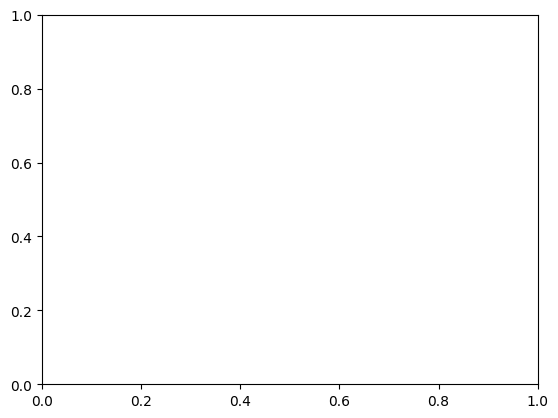

In [14]:
# model = cnn()
# model.summary()
model.compile(optimizer='adam', loss='mse',)

batch_size = 128
steps_per_epoch = len(sound_base.train_X) // batch_size

print('Starting training')

for epoch in range(8):
    print(f"Epoch {epoch + 1}")
    
    # Gera um novo lote de validação para cada época
    validation_batch = next(data_generator_val.generate_sample_pesq(batch_size=1024))
    x_val, y_val = validation_batch
        
    model.fit(data_generator_train.generate_sample_pesq(batch_size=batch_size),
              steps_per_epoch=steps_per_epoch,
              epochs=1,
              validation_data=(x_val, y_val),
              callbacks=[PlotLossesCallback()]
            )

# score = model.evaluate(X_test, y_test, verbose=0)
# print(score)
# model.save('pesq-generator-16.h5')

In [344]:
model.save('pesq-generator-16.h5')

In [21]:
from keras import backend as K

K.clear_session()

## Pré treinamento da rede para remoção de ruído

Nesta etapa, estamos utilizando a arquitetura UNet de redes neurais para
montar um modelo para a remoção de ruído

In [75]:
def unet(inputs):

    # Encoder
    conv1 = Conv1D(64, 3, activation='tanh', padding='same')(inputs)
    conv1 = Conv1D(64, 3, activation='tanh', padding='same')(conv1)
    pool1 = MaxPooling1D(pool_size=2)(conv1)
    
    conv2 = Conv1D(128, 3, activation='tanh', padding='same')(pool1)
    conv2 = Conv1D(128, 3, activation='tanh', padding='same')(conv2)
    pool2 = MaxPooling1D(pool_size=2)(conv2)
    
    # Middle
    conv3 = Conv1D(256, 3, activation='tanh', padding='same')(pool2)
    conv3 = Conv1D(256, 3, activation='tanh', padding='same')(conv3)
    
    # Decoder
    up1 = UpSampling1D(size=2)(conv3)
    up1 = Conv1D(128, 3, activation='tanh', padding='same')(up1)
    merge1 = concatenate([conv2, up1], axis=-1)
    conv4 = Conv1D(128, 3, activation='tanh', padding='same')(merge1)
    conv4 = Conv1D(128, 3, activation='tanh', padding='same')(conv4)
    
    up2 = UpSampling1D(size=2)(conv4)
    up2 = Conv1D(64, 3, activation='tanh', padding='same')(up2)
    merge2 = concatenate([conv1, up2], axis=-1)
    conv5 = Conv1D(64, 3, activation='tanh', padding='same')(merge2)
    conv5 = Conv1D(64, 3, activation='tanh', padding='same')(conv5)
    
    # Output
    output = Conv1D(2, 1, activation='tanh')(conv5)
#     output = Reshape((base_shape_size, 1))(output)

    return output

In [76]:
def squeeze_excite_block(input_tensor):
    filters = K.int_shape(input_tensor)[-1]
    se = GlobalAveragePooling1D()(input_tensor)
    se = Dense(filters // 16, activation='relu')(se)
    se = Dense(filters, activation='sigmoid')(se)
    se = Reshape((1, filters))(se)
    scaled_input = multiply([input_tensor, se])
    return scaled_input

def attention_block(encoder_output, decoder_input):
    filters = K.int_shape(decoder_input)[-1]
    encoder_attention = Conv1D(filters, 1, activation='sigmoid', padding='same')(encoder_output)
    multiplied = multiply([encoder_attention, decoder_input])
    output = Add()([multiplied, decoder_input])
    return output

In [77]:
def big_unet(inputs, filter_size=3):
    # Encoder
    conv1 = Conv1D(32, filter_size, activation='relu', padding='same')(inputs)
    conv1 = Conv1D(32, filter_size, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling1D(pool_size=2)(conv1)

    conv2 = Conv1D(64, filter_size, activation='relu', padding='same')(pool1)
    conv2 = Conv1D(64, filter_size, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling1D(pool_size=2)(conv2)

    conv3 = Conv1D(128, filter_size, activation='relu', padding='same')(pool2)
    conv3 = Conv1D(128, filter_size, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling1D(pool_size=2)(conv3)

    conv4 = Conv1D(256, filter_size, activation='relu', padding='same')(pool3)
    conv4 = Conv1D(256, filter_size, activation='relu', padding='same')(conv4)
    drop4 = Dropout(0.2)(conv4)
    pool4 = MaxPooling1D(pool_size=2)(drop4)

    conv5 = Conv1D(512, filter_size, activation='relu', padding='same')(pool4)
    conv5 = Conv1D(512, filter_size, activation='relu', padding='same')(conv5)
    drop5 = Dropout(0.2)(conv5)
    
    # Camadas LSTM
    lstm = LSTM(512, return_sequences=True)(drop5)
    lstm = LSTM(512, return_sequences=True)(lstm)

    # Decoder
    up6 = Conv1DTranspose(256, 2, strides=2, padding='same')(lstm)
    merge6 = concatenate([conv4, up6], axis=2)
    conv6 = Conv1D(256, filter_size, activation='relu', padding='same')(merge6)
    conv6 = Conv1D(256, filter_size, activation='relu', padding='same')(conv6)
    attention6 = squeeze_excite_block(conv6)  # Camada de atenção

    up7 = Conv1DTranspose(128, 2, strides=2, padding='same')(attention6)
    merge7 = concatenate([conv3, up7], axis=2)
    conv7 = Conv1D(128, filter_size, activation='relu', padding='same')(merge7)
    conv7 = Conv1D(128, filter_size, activation='relu', padding='same')(conv7)
    attention7 = squeeze_excite_block(conv7)  # Camada de atenção

    up8 = Conv1DTranspose(64, 2, strides=2, padding='same')(attention7)
    merge8 = concatenate([conv2, up8], axis=2)
    conv8 = Conv1D(64, filter_size, activation='relu', padding='same')(merge8)
    conv8 = Conv1D(64, filter_size, activation='relu', padding='same')(conv8)
    attention8 = squeeze_excite_block(conv8)  # Camada de atenção

    up9 = Conv1DTranspose(32, 2, strides=2, padding='same')(attention8)
    merge9 = concatenate([conv1, up9], axis=2)
    conv9 = Conv1D(32, filter_size, activation='relu', padding='same')(merge9)
    conv9 = Conv1D(32, filter_size, activation='relu', padding='same')(conv9)
    attention9 = squeeze_excite_block(conv9)  # Camada de atenção

    output = Conv1D(2, 1, activation='linear')(attention9)
    # output = Reshape((base_shape_size, 1))(conv10)

    return output
    
# def big_unet(inputs):
#     # Encoder
#     conv1 = Conv2D(32, 3, activation='relu', padding='same')(inputs)
#     conv1 = Conv2D(32, 3, activation='relu', padding='same')(conv1)
#     pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

#     conv2 = Conv2D(64, 3, activation='relu', padding='same')(pool1)
#     conv2 = Conv2D(64, 3, activation='relu', padding='same')(conv2)
#     pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

#     conv3 = Conv2D(128, 3, activation='relu', padding='same')(pool2)
#     conv3 = Conv2D(128, 3, activation='relu', padding='same')(conv3)
#     pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

#     conv4 = Conv2D(256, 3, activation='relu', padding='same')(pool3)
#     conv4 = Conv2D(256, 3, activation='relu', padding='same')(conv4)
#     drop4 = Dropout(0.5)(conv4)
#     pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

#     conv5 = Conv2D(512, 3, activation='relu', padding='same')(pool4)
#     conv5 = Conv2D(512, 3, activation='relu', padding='same')(conv5)
#     drop5 = Dropout(0.5)(conv5)

#     # Decoder
#     up6 = Conv2DTranspose(256, 2, strides=(2, 3), padding='same')(drop5)
#     attention6 = attention_block(drop4, up6)  # Camada de atenção
#     merge6 = concatenate([attention6, up6], axis=3)
#     conv6 = Conv2D(256, 3, activation='relu', padding='same')(merge6)
#     conv6 = Conv2D(256, 3, activation='relu', padding='same')(conv6)
#     se1 = squeeze_excite_block(conv6)  # Camada de SE

#     up7 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(se1)
#     attention7 = attention_block(conv3, up7)  # Camada de atenção
#     merge7 = concatenate([attention7, up7], axis=3)
#     conv7 = Conv2D(128, 3, activation='relu', padding='same')(merge7)
#     conv7 = Conv2D(128, 3, activation='relu', padding='same')(conv7)
#     se2 = squeeze_excite_block(conv7)  # Camada de SE

#     up8 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(se2)
#     attention8 = attention_block(conv2, up8)  # Camada de atenção
#     merge8 = concatenate([attention8, up8], axis=3)
#     conv8 = Conv2D(64, 3, activation='relu', padding='same')(merge8)
#     conv8 = Conv2D(64, 3, activation='relu', padding='same')(conv8)
#     se3 = squeeze_excite_block(conv8)  # Camada de SE

#     up9 = Conv2DTranspose(32, 2, strides=(2, 2), padding='same')(se3)
#     attention9 = attention_block(conv1, up9)  # Camada de atenção
#     merge9 = concatenate([attention9, up9], axis=3)
#     conv9 = Conv2D(32, 3, activation='relu', padding='same')(merge9)
#     conv9 = Conv2D(32, 3, activation='relu', padding='same')(conv9)
#     se4 = squeeze_excite_block(conv9)  # Camada de SE

#     conv10 = Conv2D(1, 1, activation='tanh')(se4)
#     output = Reshape((base_shape_size, 1))(conv10)
    
#     return output


In [95]:
def fcrn(input_layer, filter_size=3):
    # Camadas de convolução
    conv1 = Conv1D(64, filter_size, activation='relu', padding='same')(input_layer)
    conv1 = Conv1D(64, filter_size, activation='tanh', padding='same')(conv1)
    pool1 = MaxPooling1D(pool_size=2)(conv1)
    
    conv2 = Conv1D(128, filter_size, activation='relu', padding='same')(pool1)
    conv2 = Conv1D(128, filter_size, activation='tanh', padding='same')(conv2)
    pool2 = MaxPooling1D(pool_size=2)(conv2)
    
    # Camada LSTM
    lstm = LSTM(256, return_sequences=True)(pool2)
    
    # Camadas de upsampling
    up1 = UpSampling1D(size=2)(lstm)
    up1 = Conv1D(128, filter_size, activation='relu', padding='same')(up1)
    up1 = Conv1D(128, filter_size, activation='tanh', padding='same')(up1)

    add1 = Add()([conv2, up1])
    
    up2 = UpSampling1D(size=2)(add1)
    up2 = Conv1D(64, filter_size, activation='relu', padding='same')(up2)
    up2 = Conv1D(64, filter_size, activation='tanh', padding='same')(up2)

    output1 = Add()([conv1, up2])

    output_layer = Conv1D(2, 1, activation='linear')(output1)
    
    scaled_input = Multiply()([input_layer, output_layer])
    
    return scaled_input

In [225]:
def fcrn2(input_layer, filter_size=3):
    # Camadas de convolução
    conv1 = Conv1D(64, filter_size, activation='relu', padding='same')(input_layer)
    conv1 = Conv1D(64, filter_size, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling1D(pool_size=2)(conv1)
    
    conv2 = Conv1D(128, filter_size, activation='relu', padding='same')(pool1)
    conv2 = Conv1D(128, filter_size, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling1D(pool_size=2)(conv2)

    conv3 = Conv1D(256, filter_size, activation='relu', padding='same')(pool2)
    conv3 = Conv1D(256, filter_size, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling1D(pool_size=2)(conv3)

    # Camadas LSTM
    lstm = LSTM(512, return_sequences=True)(pool3)
    lstm = LSTM(512, return_sequences=True)(lstm)
    
    # Camadas de upsampling
    up1 = UpSampling1D(size=2)(lstm)
    up1 = Conv1D(256, filter_size, activation='relu', padding='same')(up1)
    up1 = Conv1D(256, filter_size, activation='relu', padding='same')(up1)

    add1 = Add()([conv3, up1])
    
    up2 = UpSampling1D(size=2)(add1)
    up2 = Conv1D(128, filter_size, activation='relu', padding='same')(up2)
    up2 = Conv1D(128, filter_size, activation='relu', padding='same')(up2)

    add2 = Add()([conv2, up2])

    up3 = UpSampling1D(size=2)(add2)
    up3 = Conv1D(64, filter_size, activation='relu', padding='same')(up3)
    up3 = Conv1D(64, filter_size, activation='relu', padding='same')(up3)

    add3 = Add()([conv1, up3])

    output_layer = Conv1D(2, 1, activation='linear')(add3)
    
    scaled_input = Multiply()([input_layer, output_layer])
    
    return scaled_input

In [226]:
# Função para normalizar entre -1 e 1
def normalize_output(x):
    x_min = K.min(x)
    x_max = K.max(x)
    new_min = -1
    new_max = 1
    normalized_output = (x - x_min) / (x_max - x_min) * (new_max - new_min) + new_min
    return normalized_output

In [227]:
input_pre = Input(shape=(base_shape_size, 2))

# outputs = fcrn(input_pre, filter_size=3)
# outputs = big_unet(input_pre)
outputs = fcrn2(input_pre)
# outputs = fcrn(output, filter_size=3)
# output = fcrn(output, filter_size=3)
# output_pre = Add()([input_pre, output])
# output_pre = normalize_output(output_pre)

# output = big_unet(output_pre, filter_size=5)
# output_pre = Add()([output_pre, output])
# output_pre = normalize_output(output_pre)

# output = big_unet(output_pre, filter_size=7)
# output_pre = Add()([output_pre, output])
# output_pre = normalize_output(output_pre)

modelo_pre = Model(inputs=input_pre, outputs=outputs)

In [228]:
modelo_pre.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 2000, 2)]    0           []                               
                                                                                                  
 conv1d_110 (Conv1D)            (None, 2000, 64)     448         ['input_11[0][0]']               
                                                                                                  
 conv1d_111 (Conv1D)            (None, 2000, 64)     12352       ['conv1d_110[0][0]']             
                                                                                                  
 max_pooling1d_24 (MaxPooling1D  (None, 1000, 64)    0           ['conv1d_111[0][0]']             
 )                                                                                          

In [229]:
# Crie uma instância do DataGenerator
data_generator_train_pre = DataGenerator(train_X, noise_sounds)
data_generator_val_pre = DataGenerator(val_X, noise_sounds)

In [230]:
validation_batch = next(data_generator_val_pre.generate_sample_pre(batch_size=32))
x_val, y_val = validation_batch

In [231]:
print(np.max(x_val))
print(np.max(y_val))
print(np.min(x_val))
print(np.min(y_val))
print('\n')
print(np.mean(x_val[:, :, 0]**2))
print(np.mean(y_val[:, :, 1]**2))

156.11547810156503
156.04522768397274
-125.86693760778441
-127.18646669024207


32.9421346064778
29.649849129751907


In [237]:
modelo_pre.compile(optimizer='adam', loss='mse',)

batch_size = 256
steps_per_epoch = len(train_X) // batch_size

print('Starting training')

for epoch in range(4):
    print(f"Epoch {epoch + 1}")
    # Gera um novo lote de validação para cada época
    validation_batch = next(data_generator_val_pre.generate_sample_pre(batch_size=1024))
    x_val, y_val = validation_batch
    
    modelo_pre.fit(data_generator_train_pre.generate_sample_pre(batch_size=batch_size),
              steps_per_epoch=steps_per_epoch,
              epochs=1,
              validation_data=(x_val, y_val),
             )


Starting training
Epoch 1
95/95 [==============================] - 79s 782ms/step - loss: 1.7604 - val_loss: 1.3687
Epoch 2
95/95 [==============================] - 74s 782ms/step - loss: 1.2316 - val_loss: 1.1158
Epoch 3
95/95 [==============================] - 75s 794ms/step - loss: 1.1653 - val_loss: 1.2682
Epoch 4
95/95 [==============================] - 76s 797ms/step - loss: 1.0975 - val_loss: 1.1177


In [238]:
modelo_pre.save('modelo-pre-fourier-09-06-2023.h5')

## Validação do modelo em sons pré definidos

Avaliar e validar a performance do modelo em algum
som da base com ruído pre definido
 

In [239]:
modelo_pre = load_model('modelo-pre-fourier-09-06-2023.h5')

In [240]:
sound = load_wav('./Base/BR_00400/balsen3_clean.wav')
noise = load_wav('./ESC-50-master/audio/1-7456-A-13.wav')

In [241]:
noisy_sound = somar_sinais(sound, noise[:sound.shape[0]], 10)
noisy_sound = add_white_gaussian_noise(noisy_sound, 10)
noisy_sound = np.clip(noisy_sound, -1, 1)

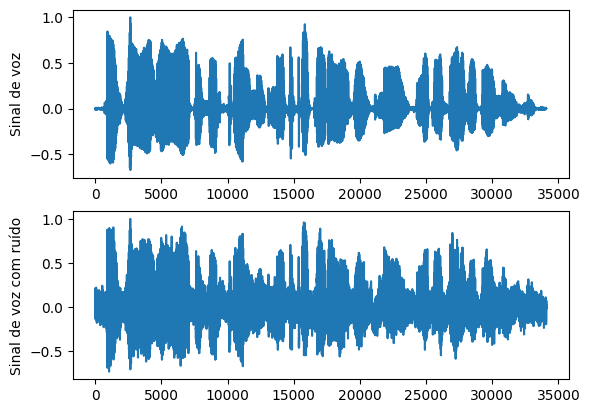

In [242]:
# Criando figuras e eixos separados para cada array
fig, (ax1, ax2) = plt.subplots(2, 1)

# Plotando o primeiro array
ax1.plot(sound)
ax1.set_ylabel('Sinal de voz')

# Plotando o segundo array
ax2.plot(noisy_sound)
ax2.set_ylabel('Sinal de voz com ruído')

# Exibindo os gráficos
plt.show()

In [243]:
r_sound = sound[:len(sound) // base_shape_size * base_shape_size].reshape(-1, base_shape_size)
r_noisy_sound = noisy_sound[:len(noisy_sound) // base_shape_size * base_shape_size].reshape(-1, base_shape_size)

In [244]:
r_sound.shape

(17, 2000)

In [245]:
comp_sound, mmm_sound = calcular_componentes_fourier(r_sound)
comp, mmm = calcular_componentes_fourier(r_noisy_sound)
filtered = modelo_pre.predict(comp.reshape(-1, base_shape_size, 2))

1/1 [==============================] - 1s 713ms/step


In [246]:
comp_sound.shape

(17, 2000, 2)

In [247]:
# o_sound = reconstruir_sinal(comp_sound, mmm_sound)

In [248]:
# save_sound_to_wav(o_sound.reshape(-1), 'test-reconstrucao.wav')
# plt.plot(o_sound.reshape(-1))

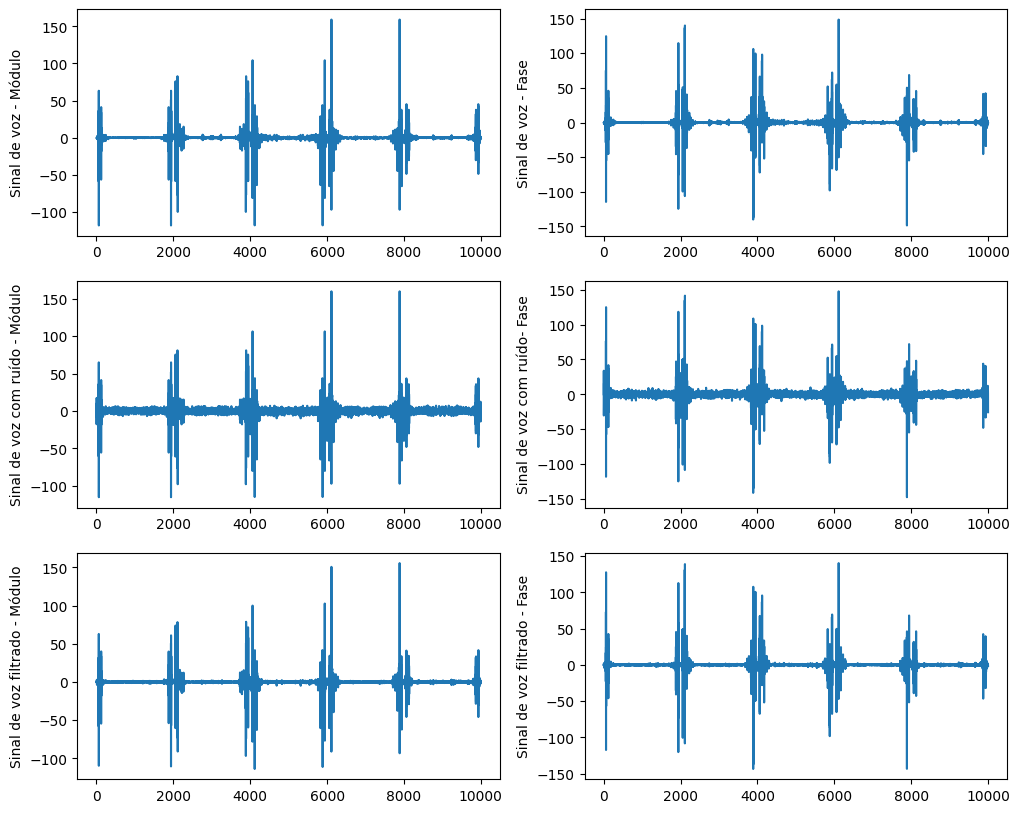

In [249]:
array_num = 0

fig, ((ax11, ax12), (ax21, ax22), (ax31, ax32)) = plt.subplots(3, 2, figsize=(12, 10))

start = 0
end = 10000

# Plotando o som original
ax11.plot(comp_sound.reshape(-1, 2)[start:end, 0])
ax11.set_ylabel('Sinal de voz - Módulo')

ax12.plot(comp_sound.reshape(-1, 2)[start:end, 1])
ax12.set_ylabel('Sinal de voz - Fase')

# Plotando o som com ruído
ax21.plot(comp.reshape(-1, 2)[start:end, 0])
ax21.set_ylabel('Sinal de voz com ruído - Módulo')

ax22.plot(comp.reshape(-1, 2)[start:end, 1])
ax22.set_ylabel('Sinal de voz com ruído- Fase')

# Plotando o som com ruído
ax31.plot(filtered.reshape(-1, 2)[start:end, 0])
ax31.set_ylabel('Sinal de voz filtrado - Módulo')

ax32.plot(filtered.reshape(-1, 2)[start:end, 1])
ax32.set_ylabel('Sinal de voz filtrado - Fase')

# Exibindo os gráficos
plt.show()

In [250]:
filtered_sound = reconstruir_sinal(filtered, 1)

(17, 2000)


In [251]:
save_sound_to_wav(sound.reshape(-1), 'original.wav')
save_sound_to_wav(noisy_sound.reshape(-1), 'ruidoso.wav')
save_sound_to_wav(filtered_sound.reshape(-1), 'filtrado.wav')

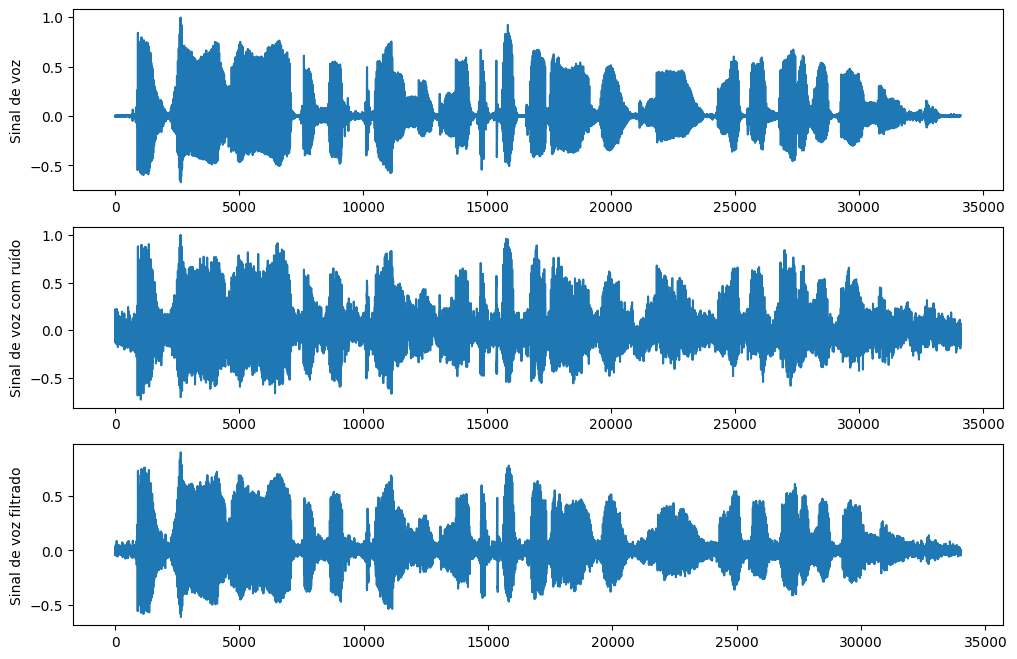

In [252]:
# Criando figuras e eixos separados para cada array
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 8))

# Plotando o primeiro array
ax1.plot(sound.reshape(-1))
ax1.set_ylabel('Sinal de voz')

# Plotando o segundo array
ax2.plot(noisy_sound.reshape(-1))
ax2.set_ylabel('Sinal de voz com ruído')

# Plotando o segundo array
ax3.plot(filtered_sound.reshape(-1))
ax3.set_ylabel('Sinal de voz filtrado')

# Exibindo os gráficos
plt.show()

In [253]:
print('SNR sinal ruidoso: {}'.format(calculate_snr(r_sound.reshape(-1), r_noisy_sound.reshape(-1))))
print('SNR sinal filtrado: {}'.format(calculate_snr(r_sound.reshape(-1), filtered_sound.reshape(-1))))

SNR sinal ruidoso: 6.8137912738144735
SNR sinal filtrado: 13.848543543880298


In [254]:
print('PESQ sinal ruidoso: {}'.format(pesq(8000, r_sound.reshape(-1), r_noisy_sound.reshape(-1), 'nb')))
print('PESQ sinal filtrado: {}'.format(pesq(8000, r_sound.reshape(-1), filtered_sound.reshape(-1), 'nb')))

PESQ sinal ruidoso: 1.4845632314682007
PESQ sinal filtrado: 1.813611626625061


## Refiltragem do sinal

1/1 [==============================] - 0s 29ms/step
(17, 2000)
SNR sinal ruidoso: 6.8137912738144735
SNR sinal filtrado: 8.884723354664917
PESQ sinal ruidoso: 1.4845632314682007
PESQ sinal filtrado: 2.1508378982543945


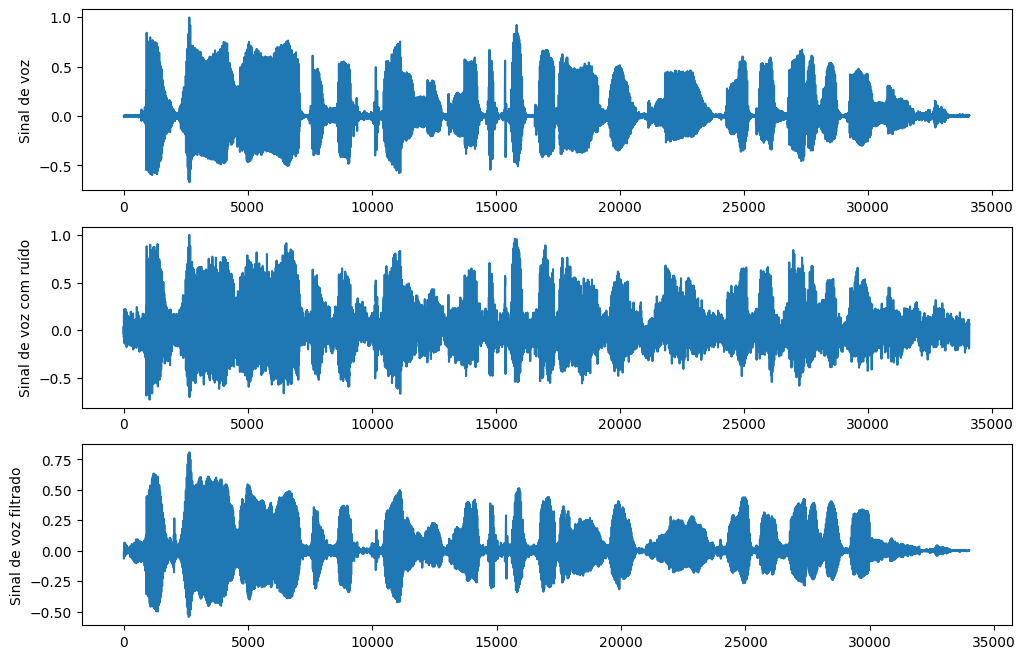

In [268]:
filtered_again = filtered
for i in range(9):
    filtered_again = modelo_pre.predict(filtered_again)

filtered_sound_again = reconstruir_sinal(filtered_again, 1)

print('SNR sinal ruidoso: {}'.format(calculate_snr(r_sound.reshape(-1), r_noisy_sound.reshape(-1))))
print('SNR sinal filtrado: {}'.format(calculate_snr(r_sound.reshape(-1), filtered_sound_again.reshape(-1))))

print('PESQ sinal ruidoso: {}'.format(pesq(8000, r_sound.reshape(-1), r_noisy_sound.reshape(-1), 'nb')))
print('PESQ sinal filtrado: {}'.format(pesq(8000, r_sound.reshape(-1), filtered_sound_again.reshape(-1), 'nb')))

save_sound_to_wav(filtered_sound_again.reshape(-1), 'filtrado_again.wav')

# Criando figuras e eixos separados para cada array
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 8))

# Plotando o primeiro array
ax1.plot(sound.reshape(-1))
ax1.set_ylabel('Sinal de voz')

# Plotando o segundo array
ax2.plot(noisy_sound.reshape(-1))
ax2.set_ylabel('Sinal de voz com ruído')

# Plotando o segundo array
ax3.plot(filtered_sound_again.reshape(-1))
ax3.set_ylabel('Sinal de voz filtrado')

# Exibindo os gráficos
plt.show()

## Compilação dos modelos treinados para refinamento


In [414]:
# Carregar o modelo treinado
modelo_treinado = load_model('pesq-generator-16.h5')

# Definir seus pesos como não treináveis
for layer in modelo_treinado.layers:
    layer.trainable = False

In [415]:
modelo_pre = load_model('modelo-pre-fourier-09-06-2023.h5')

In [416]:
input_novo = Input(shape=(base_shape_size, 2))
input_concat = Input(shape=(base_shape_size, 2))

output_novo = modelo_pre(input_novo)
output_concat = concatenate([input_concat, output_novo], axis=-1)

completo = modelo_treinado(output_concat)

modelo_final = Model(inputs=[input_novo, input_concat], outputs=completo)

In [417]:
# Crie uma instância do DataGenerator
data_generator_train = DataGenerator(train_X, noise_sounds)
data_generator_val = DataGenerator(val_X, noise_sounds)

In [418]:
modelo_final.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 2000, 2)]    0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, 2000, 2)]    0           []                               
                                                                                                  
 model_8 (Functional)           (None, 2000, 2)      4831490     ['input_9[0][0]']                
                                                                                                  
 concatenate_4 (Concatenate)    (None, 2000, 4)      0           ['input_10[0][0]',               
                                                                  'model_8[0][0]']          

In [420]:
from keras.optimizers import Adam
# from keras.callbacks import ReduceLROnPlateau
# from keras.regularizers import l2

# # Definir taxa de aprendizado e fator de decaimento
# learning_rate = 0.0001
# decay_factor = 0.1

# # Definir taxa de aprendizado para as camadas adicionais
# additional_layers_lr = 0.001

# # Definir regularização L2
# l2_regularization = 0.01

# Compilar o modelo final com os ajustes
optimizer = Adam()
modelo_final.compile(optimizer=optimizer, loss='mape')

# # Ajustar a taxa de aprendizado das camadas adicionais
# for layer in modelo_final.layers:
#     if layer.name.startswith('camadas_adicionais'):
#         layer.learning_rate = additional_layers_lr

# Definir tamanho do lote e número de passos por época
batch_size = 64
steps_per_epoch = len(train_X) // batch_size

# Definir decaimento da taxa de aprendizado
# lr_decay = ReduceLROnPlateau(factor=decay_factor)

print('Starting training')

for epoch in range(2):
    print(f"Epoch {epoch + 1}")
    
    # Gera um novo lote de validação para cada época
    validation_batch = next(data_generator_val.generate_sample_completo(batch_size=batch_size))
    x_val, y_val = validation_batch
    
    modelo_final.fit(data_generator_train.generate_sample_completo(batch_size=batch_size),
                     steps_per_epoch=steps_per_epoch,
                     epochs=1,
                     validation_data=(x_val, y_val),
#                      callbacks=[PlotLossesCallback(), lr_decay]
                    )

Starting training
Epoch 1
382/382 [==============================] - 95s 242ms/step - loss: 27.2203 - val_loss: 26.2087
Epoch 2
382/382 [==============================] - 92s 242ms/step - loss: 24.4213 - val_loss: 25.2168


In [421]:
inferencia_modelo_novo = Model(inputs=input_novo, outputs=output_novo)
inferencia_modelo_novo.save('modelo-sem-PESQ-16.h5')

# Teste do modelo refinado com a PESQ

In [422]:
inferencia_modelo_novo.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 2000, 2)]         0         
                                                                 
 model_8 (Functional)        (None, 2000, 2)           4831490   
                                                                 
Total params: 4,831,490
Trainable params: 4,831,490
Non-trainable params: 0
_________________________________________________________________


In [423]:
sound_wave = load_wav('./Base/BR_00400/balsen3_clean.wav')
noise_wave = load_wav('./ESC-50-master/audio/1-7456-A-13.wav')

In [424]:
noisy_sound_wave = somar_sinais(sound_wave, noise_wave[:sound_wave.shape[0]], 10)
noisy_sound_wave = add_white_gaussian_noise(noisy_sound_wave, 10)
noisy_sound_wave = np.clip(noisy_sound_wave, -1, 1)

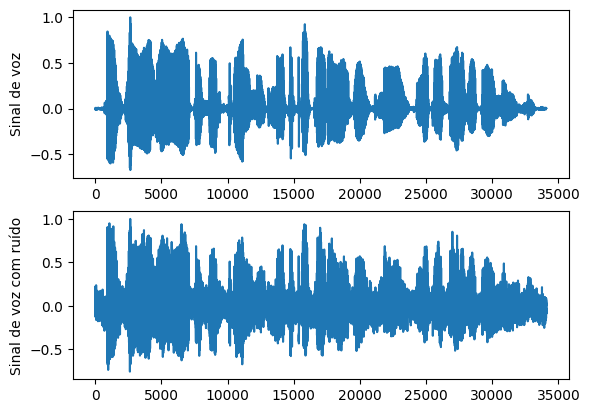

In [425]:
# Criando figuras e eixos separados para cada array
fig, (ax1, ax2) = plt.subplots(2, 1)

# Plotando o primeiro array
ax1.plot(sound_wave)
ax1.set_ylabel('Sinal de voz')

# Plotando o segundo array
ax2.plot(noisy_sound_wave)
ax2.set_ylabel('Sinal de voz com ruído')

# Exibindo os gráficos
plt.show()

In [426]:
r_sound_wave = sound_wave[:len(sound_wave) // base_shape_size * base_shape_size].reshape(-1, base_shape_size)
r_noisy_sound_wave = noisy_sound_wave[:len(noisy_sound_wave) // base_shape_size * base_shape_size].reshape(-1, base_shape_size)

In [427]:
comp_sound_wave, _ = calcular_componentes_fourier(r_sound_wave)
comp_wave, _ = calcular_componentes_fourier(r_noisy_sound_wave)
filtered_wave = inferencia_modelo_novo.predict(comp_wave.reshape(-1, base_shape_size, 2))

1/1 [==============================] - 1s 728ms/step


In [428]:
filtered_sound_wave = reconstruir_sinal(filtered_wave, 1)

(17, 2000)


In [429]:
save_sound_to_wav(sound_wave.reshape(-1), 'original_full.wav')
save_sound_to_wav(noisy_sound_wave.reshape(-1), 'ruidoso_full.wav')
save_sound_to_wav(filtered_sound_wave.reshape(-1), 'filtrado_full.wav')

SNR sinal ruidoso: 6.768246515346067
SNR sinal filtrado: 0.41617062971479724
PESQ sinal ruidoso: 1.4751694202423096
PESQ sinal filtrado: 1.8385988473892212


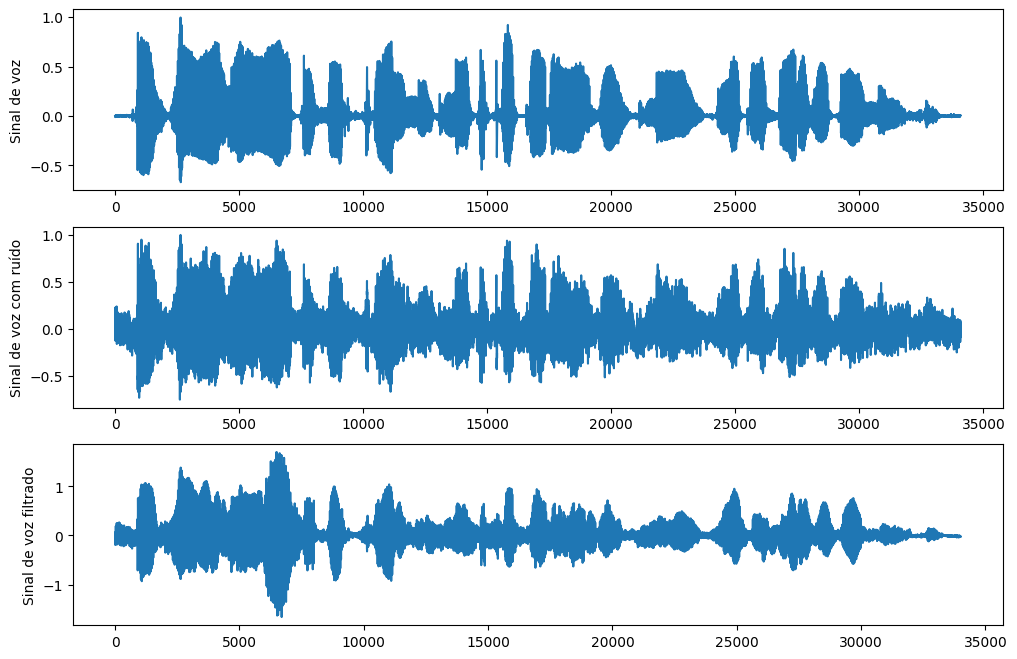

In [430]:
print('SNR sinal ruidoso: {}'.format(calculate_snr(r_sound_wave.reshape(-1), r_noisy_sound_wave.reshape(-1))))
print('SNR sinal filtrado: {}'.format(calculate_snr(r_sound_wave.reshape(-1), filtered_sound_wave.reshape(-1))))

print('PESQ sinal ruidoso: {}'.format(pesq(8000, r_sound_wave.reshape(-1), r_noisy_sound_wave.reshape(-1), 'nb')))
print('PESQ sinal filtrado: {}'.format(pesq(8000, r_sound_wave.reshape(-1), filtered_sound_wave.reshape(-1), 'nb')))

# Criando figuras e eixos separados para cada array
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 8))

# Plotando o primeiro array
ax1.plot(sound_wave.reshape(-1))
ax1.set_ylabel('Sinal de voz')

# Plotando o segundo array
ax2.plot(noisy_sound_wave.reshape(-1))
ax2.set_ylabel('Sinal de voz com ruído')

# Plotando o segundo array
ax3.plot(filtered_sound_wave.reshape(-1))
ax3.set_ylabel('Sinal de voz filtrado')

# Exibindo os gráficos
plt.show()

In [473]:
siz = 30000

In [474]:
stoi_score_noisy = stoi(r_sound_wave.reshape(-1)[:siz], r_noisy_sound_wave.reshape(-1)[:siz], 8000, extended=False)
stoi_score_filtered = stoi(r_sound_wave.reshape(-1)[:siz], filtered_sound_again.reshape(-1)[:siz], 8000, extended=False)
print(stoi_score_noisy)
print(stoi_score_filtered)

0.8035097985791513
0.7087329207890656
